# Data Analysis - China Daily

In this data analysis notebook, I will first conduct a general analysis and further clean if necessary of all publications collected for the China Daily. Specifically, I will generate a frequency list of commonly used words and phrases, followed by a KWIC analysis to investigate the contexts surrounding a select fraction of words of interest. Following the KWIC, I will conduct a collocate analysis.

- general analysis
- frequency lists
- KWIC analysis
- collocate analysis


In [135]:
import os
import json
import random
import shutil

import datetime as dt
import calendar
from nltk import tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter

In [60]:
## run the functions notebook here
%run functions.ipynb

In [61]:
## open the corpus_index file that only contains publications from China Daily
cd_corp = json.load(open('../data/text/china_daily/cd_corpus_index.json'))

In [62]:
## checking that the cd_corp is complete and contains the 32 + 411 total texts collected
len(cd_corp)

443

As correctly expected, there are 443 total texts from the China Daily. The first general analysis I will conduct is on the date of publication to see if there are any trends in terms of when output of publications may have been greater.

In [63]:
## for the first 32 publications, the date is in the format year-month-day
## extract year-month here and append to list my_date
my_date=[]
for article in cd_corp[:32]:
    date=article['Date'][:7]
    my_date.append(date)

In [64]:
## for the remaining publications, the date is in the format month/day/year
## extracting year and month and append to same list my_date

for article in cd_corp[32:]:
    date=article['Date'].split('/')
    year = '20{}'.format(date[2])
    if len(date[0]) == 1:
        month = '0{}'.format(date[0])
    else:
        month = date[0]
    month_year = '{}-{}'.format(year,month)
    my_date.append(month_year)

In [65]:
## counter and 5 most common times of publication
my_dist= Counter(my_date)
my_dist.most_common(5)

[('2020-05', 83),
 ('2020-11', 43),
 ('2020-03', 42),
 ('2020-12', 40),
 ('2020-04', 38)]

Oh wow! Lots of publications in May of 2020, followed by November 2020. I wonder if this trend will also be true for the other sources. To visualize this data, I will plot the distribution as a bar graph.

<AxesSubplot:title={'center':'China Daily'}, xlabel='date', ylabel='# Articles'>

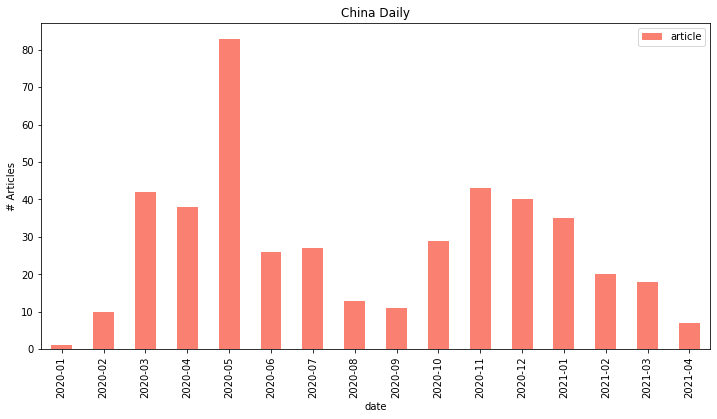

In [66]:
## bar graph of publications in each month
date_df = pd.DataFrame.from_records(list(my_dist.items()), columns=['date','article'])
date_df.sort_values('date').plot.bar(x='date',y='article', figsize=(12,6), color='salmon', title='China Daily', ylabel='# Articles')

We see the peaks in May and November of 2020. Appears like a bimodal distribution with the greatest spike in publications in May of 2020. With this trend in mind, I'm now going to look at the content of the texts and get into more specific analyses.

First I will process each text to extract just the body text.

In [67]:
characters_to_remove = '!,.()[]|"'

In [68]:
## for the first 32 articles from the bulk download, easily extract the text and add it to the dictionary
for article in cd_corp[:32]:
    filename = article['Filename']
    text = open('../data/text/china_daily/{}'.format(filename)).read()
    article['text'] = text

In [69]:
## for the 411 texts from the secondary manual download, have to extract the body text from each publication before adding to the dictionary
for article in cd_corp[32:]:
    filename = article['Filename']
    text = open('../data/text/china_daily/{}'.format(filename)).read()
    body_text_start = text.index('Body')+4
    body_text_end = text.find('Load-Date:')
    body_text=text[body_text_start:body_text_end].strip()
    article['text'] = body_text

In [70]:
## tokenize the text and add 'tokens', 'token_cnt', and 'type_cnt' to dictionary 
for article in cd_corp:
    if article.get('text'):
        cd_tokens = tokenize(article['text'], lowercase=True, strip_chars=characters_to_remove)
        article['tokens'] = cd_tokens 
        article['token_cnt'] = len(cd_tokens)
        article['type_cnt'] = len(set(cd_tokens))

In [71]:
## counters for tokens of individual words, bigrams, and trigrams
cd_token_dist=Counter()
cd_text_dist= Counter()
cd_bigram_dist=Counter()
cd_trigram_dist=Counter()

for article in cd_corp:
    if article.get('tokens'):
        cd_tokens = article['tokens']
        cd_token_dist.update(cd_tokens)
        cd_text_dist.update(set(cd_tokens))
        
        cd_bigrams=get_ngram_tokens(cd_tokens,2)
        cd_trigrams=get_ngram_tokens(cd_tokens,3)
        
        cd_bigram_dist.update(cd_bigrams)
        cd_trigram_dist.update(cd_trigrams) 

In [72]:
## top 50 most common tokens
cd_token_dist.most_common(50)

[('the', 20632),
 ('and', 10281),
 ('of', 10167),
 ('to', 9816),
 ('in', 8728),
 ('-', 8534),
 ('china', 7533),
 ('more', 7346),
 ('covid-19', 6870),
 ('read', 6383),
 ('a', 5762),
 ('on', 5277),
 ('cases', 4231),
 ('for', 3774),
 ('new', 3581),
 ('chinese', 3297),
 ('oct', 3026),
 ('all', 2701),
 ('that', 2664),
 ('as', 2654),
 ('is', 2622),
 ('coronavirus', 2411),
 ('by', 2392),
 ('outside', 2292),
 ('reports', 2246),
 ('mainland', 2245),
 ('imported', 2131),
 ('us', 2069),
 ('with', 1991),
 ('said', 1919),
 ('from', 1798),
 ('has', 1607),
 ('at', 1587),
 ('health', 1462),
 ('it', 1443),
 ('virus', 1379),
 ('have', 1355),
 ('be', 1203),
 ('global', 1194),
 ('who', 1170),
 ('are', 1147),
 ('was', 1105),
 ('countries', 1086),
 ('people', 1010),
 ('daily', 1003),
 ('an', 981),
 ('not', 908),
 ('2020', 908),
 ('control', 901),
 ('he', 899)]

Unsurprisingly the top few are words like "the", "and", "of", and "to". Additionally, as expected, China is frequently used alongside COVID-19. A few words that caught my eye include "imported", "countries", and "control".

In [73]:
## top 50 most common bigrams
cd_bigram_dist.most_common(50)

[('read more', 6281),
 ('more -', 3483),
 ('china -', 3235),
 ('covid-19 cases', 3053),
 ('of the', 2814),
 ('new covid-19', 2197),
 ('outside china', 2161),
 ('chinese mainland', 2088),
 ('all imported', 1861),
 ('- chinese', 1786),
 ('mainland reports', 1780),
 ('cases on', 1698),
 ('in the', 1431),
 ('more oct', 1396),
 ('more china', 1220),
 ('to the', 923),
 ('the virus', 884),
 ('imported read', 862),
 ('novel coronavirus', 843),
 ('for covid-19', 746),
 ('and the', 682),
 ('on the', 653),
 ('- us', 640),
 ('covid-19 read', 625),
 ('the us', 617),
 ('johns hopkins', 617),
 ('hopkins university', 617),
 ('the novel', 587),
 ('positive for', 557),
 ('for the', 540),
 ('imported oct', 540),
 ('that the', 537),
 ('prevention and', 530),
 ('the world', 527),
 ('cases surpass', 522),
 ('and control', 516),
 ('- global', 516),
 ('at the', 513),
 ('on friday', 512),
 ('on oct', 467),
 ('with the', 457),
 ('friday all', 443),
 ('university read', 443),
 ('global covid-19', 440),
 ('on thu

Looking at bigrams, I am again intrigued by the usage of "all imported" which appeared 1861 times. I'm also interested in the mention of Johns Hopkins and "outside China" as to what the context of that phrase entails. So far however, words that refer to the origins are not found in the top 50 tokens or bigrams.

In [74]:
## top 50 most common trigrams
cd_trigram_dist.most_common(50)

[('read more -', 3483),
 ('new covid-19 cases', 2108),
 ('outside china -', 1930),
 ('- chinese mainland', 1786),
 ('chinese mainland reports', 1689),
 ('covid-19 cases on', 1582),
 ('read more oct', 1305),
 ('read more china', 1220),
 ('china - chinese', 1220),
 ('more china -', 868),
 ('imported read more', 862),
 ('all imported read', 777),
 ('covid-19 read more', 625),
 ('johns hopkins university', 616),
 ('the novel coronavirus', 583),
 ('all imported oct', 540),
 ('positive for covid-19', 530),
 ('covid-19 cases surpass', 522),
 ('prevention and control', 494),
 ('cases on friday', 443),
 ('on friday all', 443),
 ('friday all imported', 443),
 ('university read more', 443),
 ('chinese mainland reported', 366),
 ('covid-19 cases all', 358),
 ('cases all imported', 358),
 ('for covid-19 read', 358),
 ('cases on thursday', 355),
 ('on thursday all', 352),
 ('thursday all imported', 352),
 ('11 new covid-19', 352),
 ('million: johns hopkins', 352),
 ('hopkins university read', 352),


Not a lot of new concepts being mentioned with the trigram frequency analysis when compared with the bigram analysis. Again we see the mention of JHU, mentions of COVID-19 cases counts and surges, China and "imported outside", and a few mentions of global and Trump. However, nothing that particularly stands out with regards to origins or conspiracy theories.

It is useful to be able to refer to one document that contains all the text, so I will quickly write out a file that consists of only the text portion of each publication.

In [75]:
## write out one doc titled cd_doc that consists of solely the texts from each publication
cd_single_text_list=[]

for article in cd_corp:
    if article.get('tokens'):
        cd_single_text_list.append(article['text'])

cd_doc = '\n---\n'.join(cd_single_text_list)
with open('../data/text/china_daily/cd_composite_text.txt','w') as out:
    out.write(cd_doc)

In [76]:
## tokenize the single doc and use counter
cd_comp_toks = tokenize(cd_doc, lowercase=True, strip_chars=characters_to_remove)
cd_comp_toks_dist = Counter(cd_comp_toks)

For the sake of analysis, I will select a handful of terms that could relate to questions surrounding the origins of COVID-19 and conspiracy theories. These words include laboratory, lab, bioweapon, market, military, cold-chain, conspiracy, army, detrick, transparency, origins, wuhan, and theory. I also added the word imported because of its high prevalence in the token frequency list previously generated.

In [77]:
## table with words, frequency in composite tokens, and normalized frequency by total token count (expressed as freq per 10000 tokens)
print("{: <20}{: <6}\t{}".format('term','China Daily Freq','Normalized Freq'))
print("="*62)
origin_terms = ['laboratory','lab','bioweapon','market','military','cold-chain','conspiracy','army','detrick', 'transparency','origins','wuhan','theory','imported']
for term in origin_terms:
    print("{: <20}{: <6}\t\t{}".format(term, cd_comp_toks_dist[term], round((cd_comp_toks_dist[term]/len(cd_comp_toks)*10000),3)))

term                China Daily Freq	Normalized Freq
laboratory          169   		4.104
lab                 217   		5.27
bioweapon           0     		0.0
market              206   		5.003
military            46    		1.117
cold-chain          52    		1.263
conspiracy          69    		1.676
army                9     		0.219
detrick             11    		0.267
transparency        25    		0.607
origins             95    		2.307
wuhan               663   		16.101
theory              40    		0.971
imported            2131  		51.751


Again we see the high usage of the word imported, used a total of 2131 times, with ~52 times per 10000 tokens. Following imported is Wuhan, which is unsurprising given that the Wuhan is the "birthplace" of COVID-19. After these two, it's a close tie between lab and market, the former referring to the conspiracy of COVID-19 originating from a lab (also related to the word laboratory) and the latter referring to the Wuhan market. I'm actually surprised by the frequency of the word cold-chain, military, and detrick, which are all related to super specific conspiracy theories. Finally, the word origins itself was used a total of 95 times, conspiracy 69 times, and theory a total of 40 times.

I am now interested in understanding the context surrounding the use of these words. I will now conduct a KWIC analysis.

First up is the word imported, which was used the most frequently of all the words included in the sampling.

In [78]:
print_kwic(make_kwic('imported',cd_comp_toks))

                 least 100 medical items  imported  from china including medical
            might have been occasionally  imported  to italy and other
                   the nation's ratio of  imported  cases from northeast asia
                     likely to have been  imported  from a foreign country
                     salmon was the only  imported  food sold at that
                 a company that supplies  imported  salmon to the market
transmission originating from contaminated  imported  food via cold-chain logistics
               or shipping containers of  imported  food in at least
                 depend heavily on goods  imported  from china and it
                     cases on friday all  imported  oct 23 outside china
                   cases on thursday all  imported  read more oct 22
                  cases on wednesday all  imported  read more oct 21
                    cases on tuesday all  imported  read more oct 20
                     cases on monday all  importe

                   cases on thursday all  imported  read more oct 22
                  cases on wednesday all  imported  read more oct 21
                    cases on tuesday all  imported  read more oct 20
                     cases on monday all  imported  read more oct 19
                     cases on sunday all  imported  read more oct 18
                  new covid-19 cases all  imported  - living novel coronavirus
              isolated from packaging of  imported  frozen food in qingdao:
                     cases on friday all  imported  read more oct 16
                   cases on thursday all  imported  read more - the
               locally transmitted and 7  imported  read more - no
                     cases on sunday all  imported  - national health commission
                  new covid-19 cases all  imported  read more east china
                     cases on friday all  imported  read more oct 9
                   cases on thursday all  imported  oct 8 china -
        

The interesting cases of imported are "prevent imported cases", in terms of minimizing the importing of cases from other countries likely through travel. The use of imported is, for a majority of the time, in the context of coming from outside China. There is also a handful of usages of imported in terms of imported frozen food, which aligns directly with the cold-chain conspiracy theory of the origins of COVID-19. It references frozen seafood, aquatic products, and general imported cold-chain food items. So even if cold-chain is not used as frequently, imported may be a useful proxy and indicator for this conspiracy theory.

In [79]:
print_kwic(make_kwic('laboratory',cd_comp_toks))

                     virus leaked from a  laboratory  in the chinese city
                    covid-19 came from a  laboratory  in wuhan central china's
                     have escaped from a  laboratory  — had no scientific
                   virus originated in a  laboratory  of the wuhan institute
                   in a chinese research  laboratory  trump last week claimed
                       covid-19 is not a  laboratory  construct or a purposefully
                  to clarify whether the  laboratory  is the research unit
                         as leaks in the  laboratory  caree vander linden the
                    virus escaped from a  laboratory  the team has been
                     virus leaked from a  laboratory  in china if the
                    team has concluded a  laboratory  leak is the least
                 two hypotheses over the  laboratory  theory one being the
epidemiological investigations and preliminary  laboratory  testing results the conclusion
   

In [80]:
print_kwic(make_kwic('lab',cd_comp_toks))

                     out of the virology  lab  in wuhan did it
                   was found outside the  lab  then brought back and
                       virus came from a  lab  in wuhan us media
              coronavirus with a chinese  lab  will distort assessments about
                     issues at the wuhan  lab  on april 15 fox
                 originated in the wuhan  lab  following the reports the
                        blame on a wuhan  lab  helps the trump administration
                     this could escape a  lab  and if this escaped
                    this escaped a wuhan  lab  the researchers would have
                  constructed virus in a  lab  or somewhere else who
                    said on thursday the  lab  is a cooperative project
                 originated in a chinese  lab  despite wide scientific consensus
                           not made in a  lab  if you look at
                         brought it to a  lab  and then it accidentally
            ac

We do see the typical usages of lab and laboratory but most relevant are the instances of the "high biosecurity lab" and mentions of leaks from a BSL-4 level lab. A majority of the instances do reference the lab-leak conspiracy theory, with many texts referencing a refutation of the theory.

In [82]:
print_kwic(make_kwic('military',cd_comp_toks))

                         know the top us  military  officer told reporters in
                     was saying that our  military  gave it to them
                          it to them our  military  did not give it
                          duty in the us  military  some are on the
                     was saying that our  military  gave it to them
                          it to them our  military  did not give it
                 chairman of the central  military  commission gave important instructions
                 than 40000 civilian and  military  medical workers who rushed
                  bases overseas? the us  military  has many biological laboratories
         dangerous disease pathogens for  military  purposes and to strengthen
                  bases overseas? the us  military  has many biological laboratories
         dangerous disease pathogens for  military  purposes and to strengthen
                    by the united states  military  geng said that working
         

In [83]:
print_kwic(make_kwic('conspiracy',cd_comp_toks))

                   weeks there have been  conspiracy  theories on social media
               to spread obviously false  conspiracy  theories about the origins
         aggressively pushing a debunked  conspiracy  theory that the coronavirus
              modified shooting down the  conspiracy  theory anthony fauci director
          demonizing china and spreading  conspiracy  theories about the pandemic's
                        focal point of a  conspiracy  theory pushed by some
            promote what are essentially  conspiracy  theories that are not
                     part by bigotry and  conspiracy  theories that grew online
             match of misinformation and  conspiracy  theories more research needed
              politicians who traffic in  conspiracy  theories or insulting language
updated: 2020-04-29 02:17 photo/agencies  conspiracy  theories suggesting that the
              further by fabricating the  conspiracy  theory that the virus
                 its sovereign

Most blatantly, examining the usage of "conspiracy" is very telling! We can see words that precede conspiracy (which will be explored further in the collocation analysis) like condemning, denouncing, dismissing, debunking, misinformation, etc. that all support the notion of denying conspiracy theories. Two great examples are with "demonizing China and spreading conspiracy theories", which is rich coming from China Daily and "aggressively pushing a debunked conspiracy" which reads as quite a loaded statement.

In [84]:
print_kwic(make_kwic('detrick',cd_comp_toks))

                  hour's drive from fort  detrick  base some people suspected
                     or usamriid at fort  detrick  maryland has resumed full
                     the closure of fort  detrick  to clarify whether the
                   the institute in fort  detrick  was suspended once in
                     they wrote --- fort  detrick  biological base is situated
                 since the outbreak fort  detrick  has been mentioned more
              importantly last july fort  detrick  was mysteriously closed and
                     the closure of fort  detrick  and an outbreak of
                   outbreak and the fort  detrick  hoping that the us
             infectious diseases at fort  detrick  was closed; 8/2019: a
                     the closure of fort  detrick  were deleted from online


Another fascinating observation is that "detrick", in reference to the military base in the US, another conspiracy theory, is mentioned in the China Daily but not all sources. We see that in context, the articles reference the closure of Fort Detrick back in July and the cast suspicion surrounding the events.

In [85]:
print_kwic(make_kwic('origins',cd_comp_toks))

                slagging match about the  origins  of the virus rudd
           conspiracy theories about the  origins  of the virus she
              statements about the exact  origins  of the outbreak meanwhile
                      a theory about the  origins  of the covid-19 virus
                 on tuesday explored the  origins  of sars-cov-2 another name
          bilateral criticisms about the  origins  of the virus so
           tasked with investigating the  origins  of the coronavirus disease
             closer to understanding the  origins  of the virus he
             independent review into the  origins  of the coronavirus and
    insulting language about virological  origins  now is the time
         international team studying the  origins  of covid-19 has expressed
                      china to trace the  origins  of the novel coronavirus
              who team investigating the  origins  of covid-19 greets liang
                    experts to trace the  origins  of

Again looking at origins is very telling as well. We see contextual words like untraceable, unknown, theories, investigations, labeling, indications, inquiries, demystifying that all demonstrate the lack of information regarding the virus' origins. From this, I'm inclined to believe that China Daily might have a more negative sentiment with regards to their coverage of these mysterious origins and a later sentiment analysis will allow me to determine whether that is the case.

In [86]:
print_kwic(make_kwic('transparent',cd_comp_toks))

                information in an honest  transparent  and responsible fashion the
                      china of not being  transparent  with data the us
                          in an open and  transparent  manner as required by
                        world in an open  transparent  and responsible manner and
                     epidemic in an open  transparent  and responsible way we
                          in an open and  transparent  manner as required by
                       a timely open and  transparent  manner as required by
                          in an open and  transparent  manner in accordance with
             and emphasized china's open  transparent  and responsible approach towards
                       and has been open  transparent  and responsible on covid-19
                    always been open and  transparent  china's prevention and control
                     as bring about more  transparent  policies a unified system
                        the world a

Transparency is a useful word to analyze because it is the opposite of the "mysterious origins" that create the foundation of these conspiracy theories. A majority of these instances demand and open transparency, most of the time applauding China's own "effective", "honest", "reliable", and "timely" transparency.

In [87]:
print_kwic(make_kwic('wuhan',cd_comp_toks))

                     the chinese city of  wuhan  geng reiterated that the
                     the virology lab in  wuhan  did it occur in
                     wet market there in  wuhan  or did it occur
                           from a lab in  wuhan  us media reported last
                   to shorthand china or  wuhan  in describing the virus
            coronavirus chinese virus or  wuhan  virus is stigmatization and
                    from a laboratory in  wuhan  central china's hubei province
                      the claim that the  wuhan  institute of virology could
                    safety issues at the  wuhan  lab on april 15
                likely originated in the  wuhan  lab following the reports
                          the blame on a  wuhan  lab helps the trump
                       if this escaped a  wuhan  lab the researchers would
                 who were evacuated from  wuhan  in china and 42
                     a laboratory of the  wuhan  institute of virolo

             reported in central china's  wuhan  city in december the
                 coronavirus read more -  wuhan  to send teams to
                         read more - the  wuhan  marathon originally set for
             reported in central china's  wuhan  city in december the
                 coronavirus read more -  wuhan  to send teams to
                         read more - the  wuhan  marathon originally set for
             reported in central china's  wuhan  city in december the
                 coronavirus read more -  wuhan  to send teams to
                         read more - the  wuhan  marathon originally set for
                       the target is the  wuhan  institute of virology a
                 07:00 health workers in  wuhan  carry out physical examinations
             reported in central china's  wuhan  city in december the
                 coronavirus read more -  wuhan  to send teams to
                         read more - the  wuhan  marathon originally se

Regarding conspiracy theories, Wuhan is used in reference to many things, the market, the lab, the outbreak, etc.

In [144]:
print_kwic(make_kwic('cold-chain',cd_comp_toks))

         personnel contaminated goods in  cold-chain  logistics animal products or
                  have been triggered by  cold-chain  imports from overseas adding
        be transmitted from contaminated  cold-chain  products to humans based
          of intensifying supervision of  cold-chain  imports especially for countries
                  still raging the study  cold-chain  food contaminationôºçthe possible origin
          contaminated imported food via  cold-chain  logistics the study said
             live novel coronavirus from  cold-chain  food products in qingdao
                the study's finding that  cold-chain  food is likely to
             the virus spreading through  cold-chain  logisticsôºçwere deemed possible liang
                       world the role of  cold-chain  and cold products in
                       globe the role of  cold-chain  and cold products in
           months show that contaminated  cold-chain  food products are the
              coronaviru

With regards to the cold-chain conspiracy theory, we see quite a few instances of the usage of cold-chain, all in reference to contaminated, packaged, and imported food items.

In [88]:
print_kwic(make_kwic('theory',cd_comp_toks))

           pushing a debunked conspiracy  theory  that the coronavirus originated
            shooting down the conspiracy  theory  anthony fauci director of
              not entertain an alternate  theory  either that someone found
                   point of a conspiracy  theory  pushed by some in
                         a reaction to a  theory  about the origins of
             been promoting the lab-leak  theory  since the pandemic first
                       look into the lab  theory  according to the new
                      of the lab release  theory  could affect scientific cooperation
          hypotheses over the laboratory  theory  one being the virus
       scientists support dismissing the  theory  that a laboratory incident
         december the widely discredited  theory  has been given prominent
                 force also rejected the  theory  that the virus was
           by fabricating the conspiracy  theory  that the virus was
          sovereignty and the consp

Theory is very much related to the conspiracy KWIC analysis and we see similar notions of "unsubstantiated", "denouncing", "US-conjured", "discredited", "debunked", all critical of those who are not China and particularly critical of the "lab leak theory" that suspects China as the culprit. 

With the KWIC analysis, I would like to conduct a collocate analysis just to reaffirm and dig deeper into some of the common words that surround the origin terms of "origins", "conspiracy", "transparent" and a few others.

In [89]:
origins_colls= Counter()
origins_colls.update(collocates(cd_comp_toks, 'origins'))

In [90]:
collocates(cd_comp_toks,'origins',win=[4,0])[:25]

['slagging',
 'match',
 'about',
 'the',
 'conspiracy',
 'theories',
 'about',
 'the',
 'statements',
 'about',
 'the',
 'exact',
 'a',
 'theory',
 'about',
 'the',
 'on',
 'tuesday',
 'explored',
 'the',
 'bilateral',
 'criticisms',
 'about',
 'the',
 'tasked']

In [91]:
for coll in ['theories','conspiracy','investigating', 'insulting','virological']:
    print("{: >20}{: >10}{: >10}".format(coll, origins_colls.get(coll), cd_comp_toks_dist.get(coll)))

            theories         1        46
          conspiracy         1        69
       investigating         4         8
           insulting         2         5
         virological         2         3


In [92]:
detrick_colls= Counter()
detrick_colls.update(collocates(cd_comp_toks, 'detrick'))

In [93]:
collocates(cd_comp_toks,'detrick',win=[4,0])[:25]

["hour's",
 'drive',
 'from',
 'fort',
 'or',
 'usamriid',
 'at',
 'fort',
 'the',
 'closure',
 'of',
 'fort',
 'the',
 'institute',
 'in',
 'fort',
 'they',
 'wrote',
 '---',
 'fort',
 'since',
 'the',
 'outbreak',
 'fort',
 'importantly']

In [94]:
for coll in ['usamriid','fort','outbreak','importantly','institute','infectious','diseases','closure','july']:
    print("{: >20}{: >10}{: >10}".format(coll, detrick_colls.get(coll), cd_comp_toks_dist.get(coll)))

            usamriid         1         2
                fort        11        12
            outbreak         3       779
         importantly         1        10
           institute         1       157
          infectious         1        84
            diseases         1        88
             closure         3        14
                july         1        42


In [95]:
lab_colls= Counter()
lab_colls.update(collocates(cd_comp_toks, 'lab'))

In [96]:
collocates(cd_comp_toks,'lab',win=[4,0])[:25]

['out',
 'of',
 'the',
 'virology',
 'was',
 'found',
 'outside',
 'the',
 'virus',
 'came',
 'from',
 'a',
 'coronavirus',
 'with',
 'a',
 'chinese',
 'issues',
 'at',
 'the',
 'wuhan',
 'originated',
 'in',
 'the',
 'wuhan',
 'blame']

In [97]:
for coll in ['out','found','from','originated','escape','blame','wuhan','constructed','made']:
    print("{: >20}{: >10}{: >10}".format(coll, lab_colls.get(coll), cd_comp_toks_dist.get(coll)))

                 out         2       283
               found         1       133
                from        20      1798
          originated        10        62
              escape         3         6
               blame         2       113
               wuhan        30       663
         constructed         3         3
                made         1       252


In [98]:
cc_colls= Counter()
cc_colls.update(collocates(cd_comp_toks, 'cold-chain'))

In [99]:
collocates(cd_comp_toks,'cold-chain',win=[4,0])[:25]

['personnel',
 'contaminated',
 'goods',
 'in',
 'have',
 'been',
 'triggered',
 'by',
 'be',
 'transmitted',
 'from',
 'contaminated',
 'of',
 'intensifying',
 'supervision',
 'of',
 'still',
 'raging',
 'the',
 'study',
 'contaminated',
 'imported',
 'food',
 'via',
 'live']

In [100]:
for coll in ['personnel','contaminated','triggered','transmitted','intensifying','study','imported','food']:
    print("{: >20}{: >10}{: >10}".format(coll, cc_colls.get(coll), cd_comp_toks_dist.get(coll)))

           personnel         1        23
        contaminated         7        22
           triggered         1        17
         transmitted         2       283
        intensifying         1         4
               study         2       165
            imported         8      2131
                food        26       234


In [101]:
conspiracy_colls= Counter()
conspiracy_colls.update(collocates(cd_comp_toks, 'conspiracy'))

In [102]:
collocates(cd_comp_toks,'conspiracy',win=[4,0])[:25]

['weeks',
 'there',
 'have',
 'been',
 'to',
 'spread',
 'obviously',
 'false',
 'aggressively',
 'pushing',
 'a',
 'debunked',
 'modified',
 'shooting',
 'down',
 'the',
 'demonizing',
 'china',
 'and',
 'spreading',
 'focal',
 'point',
 'of',
 'a',
 'promote']

In [103]:
for coll in ['spread','obviously','false','pushing','debunked','demonizing','spreading','promote']:
    print("{: >20}{: >10}{: >10}".format(coll, conspiracy_colls.get(coll), cd_comp_toks_dist.get(coll)))

              spread         1       367
           obviously         1         6
               false         1        28
             pushing         2        14
            debunked         1         6
          demonizing         1         2
           spreading         3        65
             promote         2        54


In [104]:
imp_colls= Counter()
imp_colls.update(collocates(cd_comp_toks, 'imported'))

In [105]:
collocates(cd_comp_toks,'imported',win=[4,0])[:25]

['least',
 '100',
 'medical',
 'items',
 'might',
 'have',
 'been',
 'occasionally',
 'the',
 "nation's",
 'ratio',
 'of',
 'likely',
 'to',
 'have',
 'been',
 'salmon',
 'was',
 'the',
 'only',
 'a',
 'company',
 'that',
 'supplies',
 'transmission']

In [106]:
for coll in ['medical','occasionally','salmon','transmission','likely','items']:
    print("{: >20}{: >10}{: >10}".format(coll, imp_colls.get(coll), cd_comp_toks_dist.get(coll)))

             medical         2       454
        occasionally         3         5
              salmon         5        18
        transmission         1       128
              likely         2        67
               items         1         7


Interesting patterns in terms of which collocates are higher in frequency. But they aren't that high in frequency which I'm hesitant to continue with. For example 454 in total but only 2 for medical. I'm missing a large chunk of it.

#### Additional test code

In [130]:
NRC_emolex = json.load(open('NRC_emotion_lexicon.json'))

In [131]:
NRC_emolex.keys()

dict_keys(['trust', 'fear', 'negative', 'sadness', 'anger', 'surprise', 'positive', 'disgust', 'joy', 'anticipation'])

In [132]:
def score_emotion(text, emolex=NRC_emolex):
    for emotion, words in emolex.items():
        article[emotion] = [a for a in article['tokens'] if a.lower() in words]

In [133]:
# select texts with specific origin terms
origin_txt_cd=[]
for word in origin_terms:
    for article in cd_corp:
        if article in origin_txt_cd:
            continue
        elif article['tokens'].count(word)>0:
            origin_txt_cd.append(article)
            score_emotion(article)

In [111]:
# number narrowed down
len(origin_txt_cd)

361

In [113]:
# percentage of all cd texts
round(len(origin_txt_cd)/len(cd_corp)*100,2)

81.49

In [114]:
# write out as doc
terms_only_txt=[]
for article in origin_txt_cd:
    terms_only_txt.append(article['text'])
    
terms_only_doc = '\n---\n'.join(terms_only_txt)
with open('../data/text/china_daily/cd_terms_only_texts.txt','w') as out:
    out.write(terms_only_doc)